In [1]:
ROOT_PATH = '../../../../'
MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist/class_conditional_38_binarised/'
BASE_LOG_PATH = ROOT_PATH + 'SVIExtensionExperiment/'  # '/None/'

# Setup

In [3]:
%matplotlib inline
import sys
import os

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

import traceback
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

In [4]:
from deepscm.datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(MNIST_DATA_PATH, train=False, columns=['thickness', 'intensity'])

In [5]:
from deepscm.morphomnist import measure

In [6]:
df = pd.read_csv(f'{MNIST_DATA_PATH}t10k-morpho.csv')

In [7]:
from deepscm.submodules.morphomnist.morphomnist import io, morpho, perturb
from deepscm.datasets.morphomnist import load_morphomnist_like, save_morphomnist_like

train_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised/'
train_images, train_labels, train_metrics = load_morphomnist_like(train_data_path, train=False)

test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised_i_100/'
test_images, test_labels, test_metrics = load_morphomnist_like(test_data_path, train=False)

In [8]:
# from deepscm.datasets.morphomnist.create_synth_thickness_intensity_data import model as true_model
from deepscm.experiments import morphomnist_reversed_arrows
from deepscm.experiments.morphomnist_binary_labels.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [23]:
from utee import selector
from torch.autograd import Variable
# model_raw, ds_fetcher, is_imagenet = selector.select('mnist')
ds_val = ds_fetcher(batch_size=256, train=False, val=True)
for idx, (data, target) in enumerate(ds_val):
    data =  Variable(torch.FloatTensor(data)).cuda()
    print(data.shape, data.min(), data.max())
    output = model_raw(data)
    print(output.shape)
    break

Building MNIST data loader with 1 workers
torch.Size([256, 1, 28, 28]) tensor(-0.4242, device='cuda:0') tensor(2.8215, device='cuda:0')
torch.Size([256, 10])


In [83]:
model_raw

MLP(
  (model): Sequential(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (relu1): ReLU()
    (drop1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (relu2): ReLU()
    (drop2): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=256, out_features=10, bias=True)
  )
)

[3 3 3 3 3 2 3 3 3 8 3 3 3 3 3 3 8 3 3 3]
[3 3 3 3 3 0 3 3 3 8 3 3 3 3 3 3 8 3 3 3]

acc: 0.5982862903225806
f1: 0.3900330536486143
[3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3]

acc: 0.5337701612903226
f1: 0.33124339792612306
[3 3 3 3 8 3 3 3 3 3 3 8 1 3 8 3 3 8 3 5]
[3 3 3 3 8 3 3 3 3 3 3 8 0 3 8 3 3 8 3 0]

acc: 0.28377016129032256
f1: 0.1605448131763921


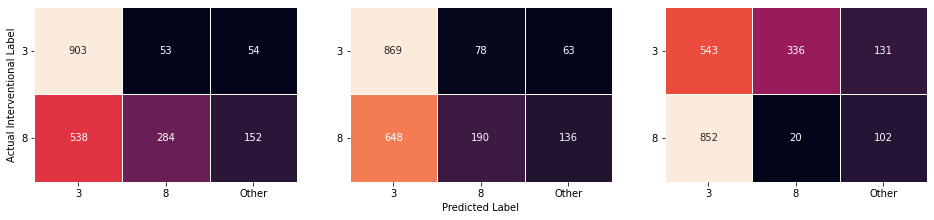

In [82]:
from sklearn import metrics
import seaborn as sns
from torchvision import transforms

model_name = 'ConditionalClassReversedVISEM'

labels = test_labels.copy()
labels[test_labels == 0] = 3
labels[test_labels == 1] = 8

width = 16
height = width / (1.618 * 2)
fig, axes = plt.subplots(1, 3, figsize=(width, height))

for i, v in enumerate([131, 133, 140]):
    cfs_loc = f'{model_name}_version_{v}_do_l.npy'
    cfs = np.load(cfs_loc)
    transform = transforms.Compose([transforms.Normalize((0.1307,), (0.3081,))])
    transformed = transform(torch.tensor(cfs))
    out = torch.argmax(model_raw(transformed.cuda()), 1)
    
    _out = out.cpu().numpy()
    print(_out[:20])
    _out[(_out != 3) & (_out != 8)] = 0
    print(_out[:20])
    
    cm = metrics.confusion_matrix(y_true=labels, y_pred=_out, labels=[3, 8, 0])
    print()

    print('acc:', metrics.accuracy_score(labels, _out))
    print('f1:', metrics.f1_score(labels, _out, average='macro'))

    ax = sns.heatmap(cm[[0, 1], :], annot=True, linewidths=.5,
                     square=True, fmt="d", cbar=False, ax=axes[i])
    ax.set_yticklabels(['3', '8'], rotation=0)
    ax.set_xticklabels(['3', '8', 'Other'])
    
    if i == 0:
        ax.set_ylabel('Actual Interventional Label')
        
    if i == 1:
        ax.set_xlabel('Predicted Label')
        
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(f'downstream_classification.pdf')

In [87]:
%%bash
ls -la ../../../../assets/data/morphomnist/class_conditional_38_binarised_i_100

total 14780
drwxr-xr-x 18 rrr2417 cs4       25 Jun 11 00:52 .
drwxr-xr-x  5 rrr2417 cs4        5 Apr  3 19:18 ..
-rw-r--r--  1 rrr2417 cs4      109 Jun  8 00:10 args.txt
drwxr-xr-x  2 rrr2417 cs4        9 Mar  7 10:36 class_conditional_38
drwxr-xr-x  2 rrr2417 cs4       10 Jun 10 03:29 class_conditional_38_binarised
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:29 class_conditional_38_binarised_i_100
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:28 class_conditional_38_binarised_i_m_75
drwxr-xr-x  2 rrr2417 cs4        8 Mar  8 10:23 class_conditional_38_binarised_ood_small
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:11 class_conditional_38_binarised_t_2
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:17 class_conditional_38_binarised_t_m_1
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:18 class_conditional_38_binarised_t_m_1_5
drwxr-xr-x  2 rrr2417 cs4        6 Jun 10 22:16 class_conditional_38_binarised_t_m_2
drwxr-xr-x  2 rrr2417 cs4       11 Jun 10 02:47 intensity_causes_thickness
drwxr-x

In [89]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'

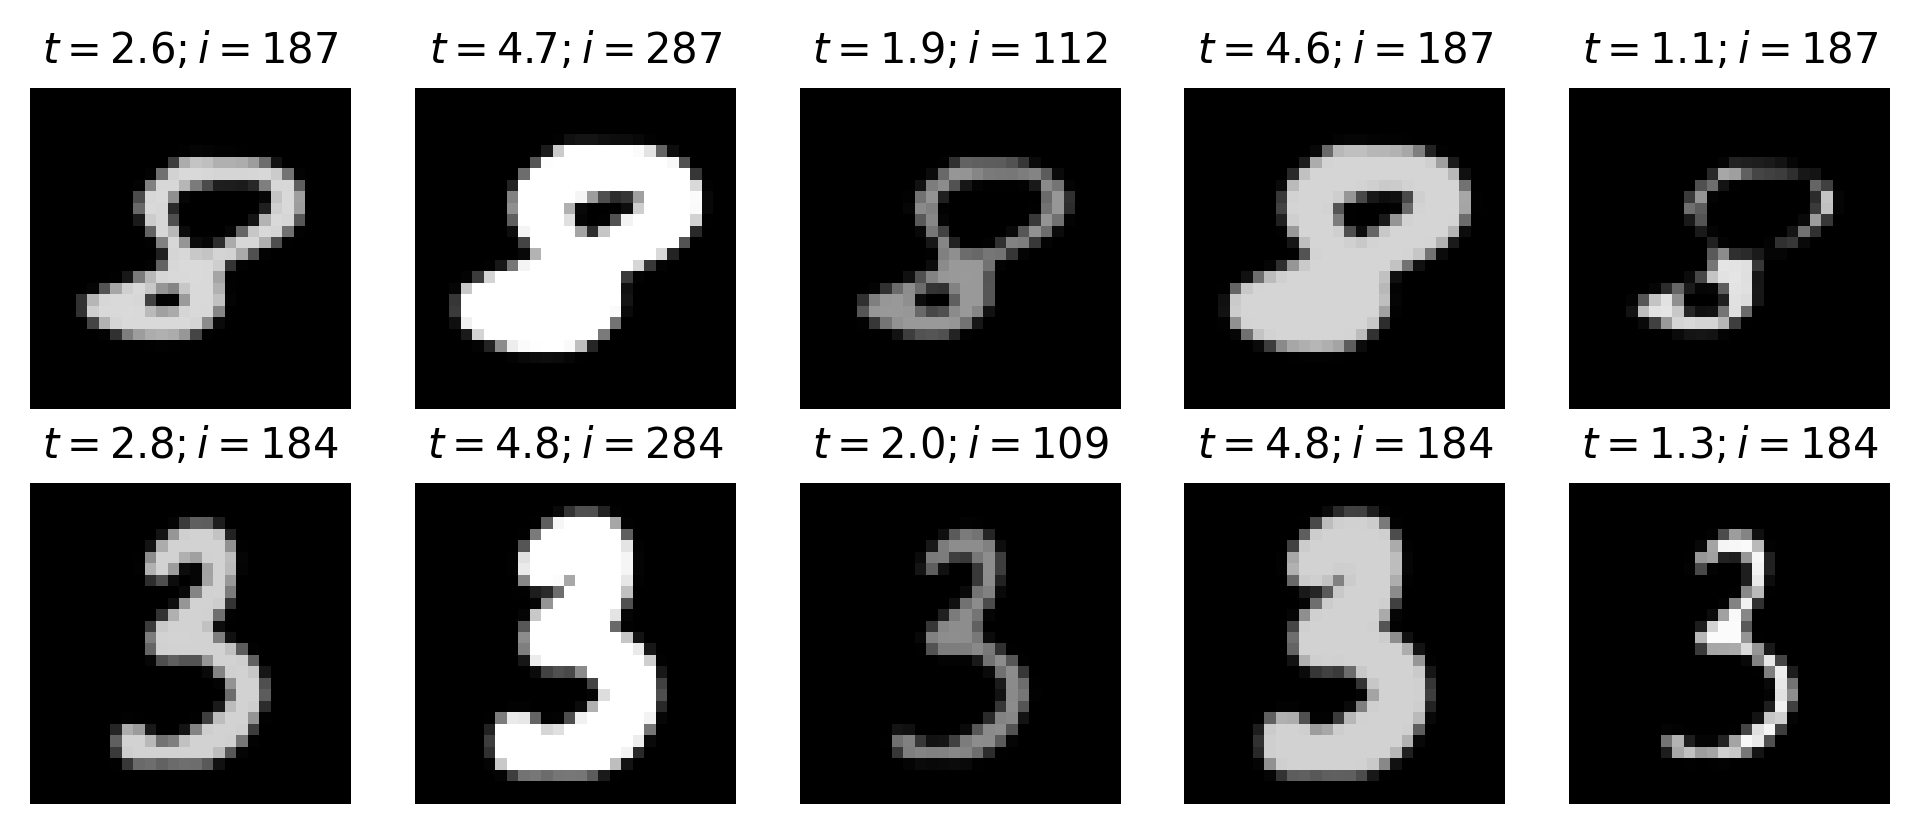

In [93]:
idx = 0

x = ['', '_i_100', '_i_m_75', '_t_2', '_t_m_1_5']

num_cols = 5
num_rows = 2

num = num_cols * num_rows

samples = []
for i in x:
    test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised{i}/'
    test_data = MorphoMNISTLike(test_data_path, train=False, columns=['thickness', 'intensity'])
    samples.append(test_data[5])
for i in x:
    test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised{i}/'
    test_data = MorphoMNISTLike(test_data_path, train=False, columns=['thickness', 'intensity'])
    samples.append(test_data[8])
    
samples = {
    'x': [x['image'] for x in samples],
    'thickness': [x['thickness'] for x in samples],
    'intensity': [x['intensity'] for x in samples],
}

save_name = 'synth_mnist_samples'

fig = plt.figure(figsize=(num_cols * 1.6, num_rows * 1.6))
gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

for i in range(num):
    x = samples['x'][i]

    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    thickness = samples['thickness'][i].item()
    intensity = samples['intensity'][i].item()
    ax.set_title(f'$t={thickness:.1f}; i={intensity:.0f}$', fontsize=10)
    ax.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"figures/morphomnist.pdf", bbox_inches='tight', pad_inches=0)

plt.show()